This is a dataset that contains 3d - rendered images of LEGO bricks. The goal is to classify the different pieces.

First, we need to import packages required for processing the images.

In [1]:
### imports
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from glob import glob
import h5py

Below, get a list of the locations of all the images in the dataset

In [2]:
prefix = "./data/dataset/"
raw_img_locs = glob("./data/dataset/*.png")
print(len(raw_img_locs), "samples identified")

40000 samples identified


Below, parse out the name of the brick peice from the name of the file

In [3]:
classnames = []
for i in range(len(raw_img_locs)):
    temp = raw_img_locs[i].split("/")[-1].split(" ")
    temp_str = ""
    for j in range(len(temp) - 1):
        temp_str += temp[j] + " "
    classnames.append(temp_str[:-1])

Below, do some work to determine the unique class names and map them to integer class numbers:

In [4]:
unique_vals = []
unique_counts = []
class_val = dict()
for i in range(len(classnames)):
    if classnames[i] not in unique_vals:
        unique_vals.append(classnames[i])
        unique_counts.append(1)
        class_val[classnames[i]] = len(unique_vals) - 1
    else:
        unique_counts[class_val[classnames[i]]] += 1

print(len(unique_vals), "classes")

for i in range(len(unique_vals)):
    print(unique_vals[i], " - ", unique_counts[i])

50 classes
4286 roof tile 1x3  -  800
3045 roof corner outside tile 2x2  -  800
3068 flat tile 2x2  -  800
3021 plate 2x3  -  800
2780 Peg with friction  -  800
6632 lever 3M  -  800
3002 brick 2x3  -  800
3675 roof tile outside 3x3  -  800
3024 plate 1x1  -  800
3062 Round Brick 1x1  -  800
14719 flat tile corner 2x2  -  800
43857 beam 1x2  -  800
27925 flat tile round 2x2  -  800
3623 Plate 1x3  -  800
6143 Brick D16 w cross  -  800
3005 brick 1x1  -  800
3004 brick 1x2  -  800
3010 brick 1x4  -  800
41677 lever 2M  -  800
54200 roof tile 1x1  -  800
85984 roof tile 1x2  -  800
4490 brick bow 1x3  -  800
18654 beam 1M  -  800
3001 brick 2x4  -  800
3003 brick 2x2  -  800
3022 Plate 2x2  -  800
43093 Bush 2M friction - Cross axle  -  800
3038 roof tile 2x3  -  800
3023 Plate 1x2  -  800
3794 Plate 1X2 with 1 Knob  -  800
3037 roof tile 1x4  -  800
3020 plate 2x4  -  800
2420 plate corner 2x2  -  800
41678 Cross Block Fork 2x2  -  800
99301 roof tile inside 3x3  -  800
15672 roof tile 

Below, pick 5 samples at random and display the sample images:

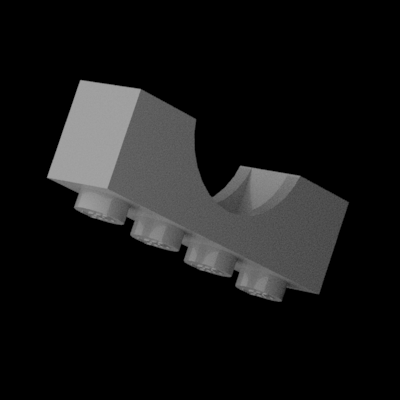

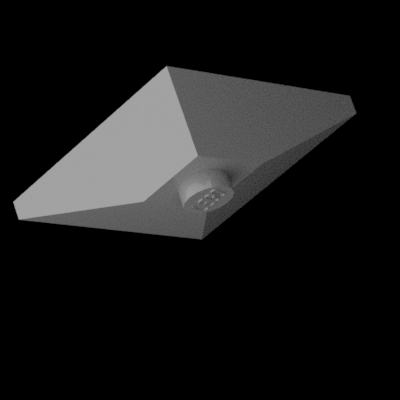

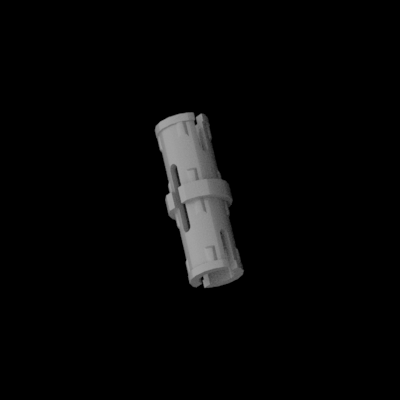

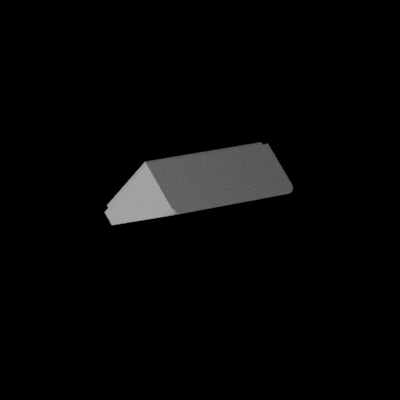

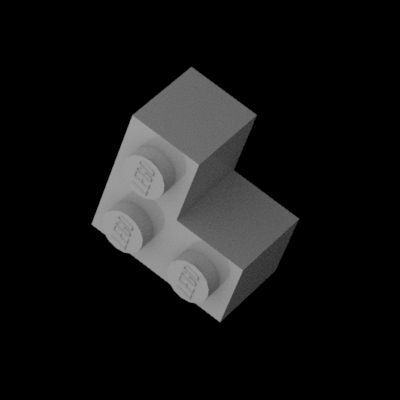

(400, 400, 3)


In [5]:
sample_imgs = np.random.randint(0, len(raw_img_locs), size=(5,))
for id in sample_imgs:
    timg = Image.fromarray(cv2.imread(raw_img_locs[id]))
    display(timg)
print(cv2.imread(raw_img_locs[0]).shape)

Below, combine locations, class names, and class numbers in one array:

In [6]:
### make y dset
dataset = []
for i in range(len(raw_img_locs)):
    dataset.append([raw_img_locs[i], classnames[i], class_val[classnames[i]]])

Save that array as a pandas dataframe

In [7]:
data_df = pd.DataFrame(dataset)
print(data_df.head)

<bound method NDFrame.head of                                                        0  \
0             ./data/dataset/4286 roof tile 1x3 346R.png   
1      ./data/dataset/3045 roof corner outside tile 2...   
2             ./data/dataset/3068 flat tile 2x2 334L.png   
3                 ./data/dataset/3021 plate 2x3 321L.png   
4         ./data/dataset/2780 Peg with friction 204L.png   
...                                                  ...   
39995             ./data/dataset/3002 brick 2x3 346R.png   
39996  ./data/dataset/27925 flat tile round 2x2 361R.png   
39997             ./data/dataset/3623 Plate 1x3 160L.png   
39998             ./data/dataset/43857 beam 1x2 100L.png   
39999  ./data/dataset/14719 flat tile corner 2x2 323R...   

                                       1   2  
0                     4286 roof tile 1x3   0  
1      3045 roof corner outside tile 2x2   1  
2                     3068 flat tile 2x2   2  
3                         3021 plate 2x3   3  
4             

Write the dataframe to .csv file:

In [8]:
data_df.to_csv("./data/dataset_df.csv")

PROBLEM -- it takes a long time to load the images to np array from their original image format. This makes training impossibly slow, on the order of 2 hours per epoch for my models, since the images must be batch loaded.

I want to get around this by pre-loading them and saving them in one big h5 dataset -- this format allows much quicker reading from disk.

Below, I load the image files, convert them to numpy arrays, and save them to the h5 database.

In [9]:
### convert images to hdf5?
h5_dataset = h5py.File("./data/x_h5.h5", "a")
h5chunksize = 1000
h5dset = h5_dataset.create_dataset("data", (h5chunksize, 400, 400, 3),
                                           maxshape=(None, 400, 400, 3),
                                           chunks=(h5chunksize, 400, 400, 3))
chunk_id = 0
idx = 0
chunk_np = np.zeros((1000, 400, 400, 3))
for i in range(len(raw_img_locs)):
    chunk_np[idx] = cv2.imread(raw_img_locs[i])
    idx += 1
    if idx == h5chunksize:
        idx = 0
        chunk_id += 1
        h5dset.resize(i+1, axis=0)
        h5dset[i+1-h5chunksize:i+1,:,:,:] = np.array(chunk_np[:,:,:,:])

In [11]:
h5_dataset.close()